# Física Computacional, 2022-1

## PROYECTO FINAL: *Método de Hartree-Fock*

### - Maldonado Cortés Fernando

In [1]:
#Librerías
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from sympy import oo
from sympy.plotting import plot
from itertools import product
from scipy.linalg import eig
from IPython.display import Math

%matplotlib inline
sp.init_printing()
r, r1, r2, z, z1, z2 = sp.symbols("r, r1, r2, z, z1, z2")  #Variables que utilizaremos frecuentemente
n = sp.Symbol('n',integer=True)

<h3><center>1. Definición de funciones</center></h3>

- **Función base (o prueba)** 

La función *espín orbital* propuesta será de la forma
$$\chi(\vec{x})=\begin{cases}
\phi(\vec{r})\alpha(\omega)\\
\phi(\vec{r})\beta(\omega)
\end{cases}$$
Donde $\alpha$ y $\beta$ son las funciones de *espín* y son tales que
$$\hat{S_z}\alpha=\frac{1}{2}\alpha$$
$$\hat{S_z}\beta=-\frac{1}{2}\beta$$
Hay dos tipos posibles para la función *orbital*:
- Gaussiana
$$\phi(\vec{r})= N_{l} r^{l} e^{-ar^2}$$
- Slater (*STO*)
$$\phi(\vec{r})= N_{n} r^{n-1} e^{-\zeta r}$$

Donde N es una constante de normalización y en el caso de la función orbital tipo Slater está dada como:
$$N_n=(2\zeta)^n\sqrt{\frac{2\zeta}{(2n)!}}$$

In [2]:
#Función orbital tipo Slater (Slater-type orbital)
def STO(z, n, r=r):
    return (2*z)**n*(2*z/sp.factorial(2*n))**(1/2)*r**(n-1)*sp.exp(-z*r)
STO(z,1)

- **Métodos de integración numérica**

In [3]:
#Método de Simpson para integrales impropias (0,inf)
def simpson(f, n):
    F=lambda u: f(u/(1-u))*(1-u)**(-2)
    a,b=0.0,0.9999999999999999
    h=(b-a)/n
    s=0.0
    x=a + h
    for i in range(1,n,2):
        s += 4*F(x)
        x += 2*h

    x = abs(a + 2*h)
    for i in range(2,n,2):
        s += 2*F(x)
        x += 2*h
    return (h/3)*(F(a)+F(b)+s)

#Método de Romberg para integrales finitas
def trapecio_reducido(f,a,b,N):
    h=(b-a)/N
    s=0  #s=0.5*f(a)+0.5*f(b) metemos esto en el for
    for k in range(1,N//2+1):
        s+=f(a+(2*k-1)*h)
    return s*h

def romberg(f,a,b,epsilon=1e-12):
    I = (b-a)/2*(f(b)+f(a)) #capa cero de la recursividad. En realidad es la forma de trapecio modificada 
    #(análogo a diferencias divididas pero con integración)
    eps=1
    N=1
    R =np.zeros((100,100)) 
    R[0,0]=I
    i=0
    while eps>epsilon:
        N*=2
        i+=1
        R[i,0] = R[i-1,0]/2 + trapecio_reducido(f,a,b,N)
        for m in range(i):
            R[i,m+1] =R[i,m] + 1/(4**(m+1)-1)*(R[i,m] - R[i-1,m])
            eps = abs(R[i,m+1]-R[i-1,m])
    I= R[i,m+1]
    return I

- **Hamiltoniano**

$$H = \int_{0}^\infty \phi_1 \hat{H} \phi_2 \; r^2dr$$

$$H = \int_{0}^\infty \phi_1 \left[\left(-\frac{1}{2}\right) \nabla^2 - \dfrac{Z_{\alpha}}{r}\right]\phi_2 \; r^2 dr$$

El operador Laplaciano en coordenadas esféricas está dado como:

\begin{equation}
\nabla^2 f= \frac{1}{r^2} \frac{\partial}{\partial r}\left(r^2 \frac{\partial f}{\partial r}\right) + \frac{1}{r^2 \sin\theta} \frac{\partial }{\partial \theta}\left(\sin\theta \frac{\partial f}{\partial \theta}\right)+\frac{1}{r^2\sin^2\theta} \frac{\partial^2 f}{\partial \varphi^2}
\end{equation}

Si $f$ no tiene parte angular, entonces esto se simpifica

\begin{equation}
\nabla^2 f= \frac{1}{r^2} \frac{\partial}{\partial r}\left(r^2 \frac{\partial f}{\partial r}\right) = \frac{1}{r} \frac{\partial^2 }{\partial r^2}(rf)
\end{equation}

$$\therefore H = \int_{0}^\infty \phi_1 \left[-\frac{1}{2r}  \frac{\partial^2}{\partial r^2}  (r \phi_2) - \dfrac{Z_{\alpha}}{r} \phi_2 \right]r^2\;dr$$

En este caso para el átomo de Helio, $Z_\alpha=2$.

In [4]:
#Integral <1|H|2>
def H_int(phi1, phi2, Z):
    D2=sp.diff(sp.diff(r*phi2,r), r)
    g = lambda x: phi1.evalf(subs={r:x})*(-x)*((D2.evalf(subs={r:x})/2)+Z*phi2.evalf(subs={r:x}))
    return simpson(g, 200)

Por otro lado, también necesitaremos calcular
$$S = \int_0^\infty \phi_1^* \phi_2 r^2 dr$$

In [5]:
# Integral <1|2>
def S_int(phi1, phi2):
    g = lambda x: phi1.evalf(subs={r:x})*phi2.evalf(subs={r:x})*(x**2)
    return simpson(g, 200)

In [6]:
# Matriz de valores <1|H|2>
def H_mat(fs, Z):
    H = np.zeros((len(fs),len(fs)))
    for i in range(len(fs)):
        for j in range(len(fs)):
            H[i, j] =  H_int(fs[i], fs[j], Z)
    return H    

# Matriz de valores <1|2>
def S_mat(fs):
    S = np.zeros((len(fs),len(fs)))
    for i in range(len(fs)):
        for j in range(len(fs)):
            S[i, j] =  S_int(fs[i], fs[j])
    return S  

- **Integral de repulsión entre electrones**
$$(rs|tu) = \int \int \dfrac{\phi_r^*(1) \phi_s(1) \phi_t^*(2) \phi_u(2)}{r_{12}} \; r_1^2 dr_1\; r_2^2 dr_2 $$

$$(rs|tu) = \int_{0}^\infty \phi_r^*(1) \phi_s(1)  \; r_1^2dr_1\int_{0}^\infty \frac{ \phi_t^*(2) \phi_u(2)}{r_{12}}\; r_2^2dr_2  $$

$$(rs|tu) = \int_{0}^\infty \phi_r^*(1) \phi_s(1)  \; r_1^2\;dr_1\left[ \int_{0}^{r_1} \frac{\phi_t^*(2) \phi_u(2)}{r_{1}}\; r_2^2dr_2 + \int_{r_1}^\infty \frac{\phi_t^*(2) \phi_u(2)}{r_{2}}\; r_2^2\;dr_2 \right]$$

$$\therefore (rs|tu) = \int_{0}^\infty \phi_r^*(1) \phi_s(1) B \; r_1^2 dr_1  $$

Donde

$$ B= \int_{0}^{r_1} \frac{\phi_t^*(2) \phi_u(2)}{r_{1}}\; r_2^2dr_2 + \int_{r_1}^\infty \frac{\phi_t^*(2) \phi_u(2)}{r_{2}}\; r_2^2dr_2$$

In [7]:
def repulsion_int(zetas):
    
    f1=STO(zetas[0][0], zetas[0][1], r1)
    f2=STO(zetas[1][0], zetas[1][1], r1)
    f3=STO(zetas[2][0], zetas[2][1], r2)
    f4=STO(zetas[3][0], zetas[3][1], r2)
    fs = [f1, f2, f3, f4]
    
    B = (1/r1)*sp.integrate(f3*f4*r2*r2 ,(r2, 0, r1)) + sp.integrate((1/r2)*f3*f4*r2*r2 ,(r2, r1, +oo))
    A = sp.integrate(f1*f2*r1*r1*B ,(r1, 0, +oo))
    return A

- **Matriz de densidad**

$$ P_{tu} =2 \sum_{j=1}^{n/2}c_{tj}^* c_{uj} $$

In [8]:
# Matriz de densidad
def P_mat(C):
    P = np.zeros([C.shape[0], C.shape[0]])
    for t in range(C.shape[0]):
        for u in range(C.shape[0]):
            for j in range(int(C.shape[0]/2)):
                P[t][u] += 2* C[t][j]*C[u][j]
    return P  

- **Matriz de Fock**
$$ F_{rs} = H_{rs} + \sum_{t=1}^{b} \sum_{t=1}^{b}P_{tu}[(rs|tu)- \frac{1}2(ru|ts)] $$

$$G = \sum_{t=1}^{b} \sum_{t=1}^{b}P_{tu}[(rs|tu)- \frac{1}2(ru|ts)]$$

$$ F_{rs} = H_{rs} + G $$  

$(rs|tu)$ es la integral de repulsion y $(ru|ts)$ es la integral de intercambio.

In [9]:
def R_mat(zetas):
    R = np.zeros((len(zetas), len(zetas), len(zetas), len(zetas)))

    rs = list(product(range(len(zetas)),repeat=2))
    tu = list(product(range(len(zetas)),repeat=2))

    for r, s in rs:
        for t, u in tu:
            R[r,s,t,u] = repulsion_int((zetas[r], zetas[s], zetas[t], zetas[u]))
    return R



def G_mat(zetas, C, R):
    G = np.zeros((C.shape[0], C.shape[0]))
    P = P_mat(C)
    rs = list(product(range( C.shape[0]),repeat=2))
    tu = list(product(range( C.shape[0]),repeat=2))
    for r, s in rs:
        g = 0
        for t, u in tu:
            int1 = R[r, s, t, u]
            int2 = R[r, u, t, s]
            g+= P[t, u] * (int1 - 0.5 * int2)
        G[r, s] = g
    return G

# Matriz de Fock
def F_mat(fs, Z, zetas, C, R):
    return H_mat(fs, Z) + G_mat(zetas, C, R)

- **Solución a la ecuación secular**

$$det(F_{rs}-\epsilon_i S_{rs})=0$$

El valor $\epsilon_i$ que cumple esta ecuación es la energía orbital de un solo electrón.

In [10]:
def secular(F, S):
    ei, C = eig(F, S)
    
    # organiza los indices de menor a mayor
    ind = ei.argsort()[::1]   
    ei = ei[ind]
    C = C[:,ind]

    # normalizamos los eigenvectores
    Co = np.zeros((C.shape[0],C.shape[0]))
    inte = np.matmul(np.matmul(C.T, S), C)
    for i in range(C.shape[0]):
        for j in range(C.shape[0]):
            Co[j][i]=C[j][i]/np.sqrt(inte[i][i])

    return ei, Co

- **Energía atómica (total)**
$$ E_{HF} = \sum_{i=1}^{2/n}\epsilon  +\frac{1}2 \sum_{r=1}^{b} \sum_{s=1}^{b}P_{rs}H_{rs}+V_{NN} $$

In [11]:
def E_HF(e, P, H):
    E0 = 0
    for i in range(int(e.shape[0]/2)):
        E0 += e[i].real 
    E0 = E0 + 0.5*(P*H).sum()
    return E0 

<h3><center>2. Implementación del método</center></h3>

---------------------------------------- Aproximación inicial ----------------------------------------
Función Orbital


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Función de onda aproximada


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Energías de cada electrón


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Energía total del átomo


<IPython.core.display.Math object>

-------------------------------------------------- Iteración # 1 --------------------------------------------------


<IPython.core.display.Math object>

Función de onda aproximada


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

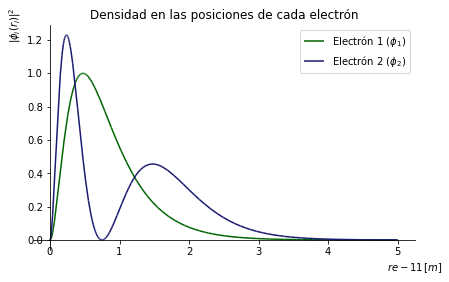

Energías de cada electrón


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Energía total del átomo


<IPython.core.display.Math object>

-------------------------------------------------- Iteración # 2 --------------------------------------------------


<IPython.core.display.Math object>

Función de onda aproximada


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

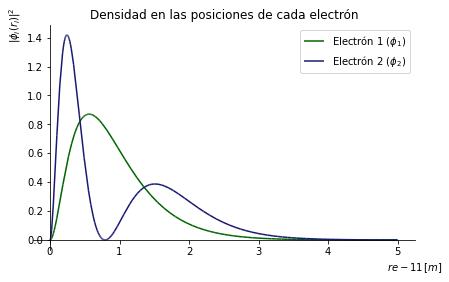

Energías de cada electrón


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Energía total del átomo


<IPython.core.display.Math object>

-------------------------------------------------- Iteración # 3 --------------------------------------------------


<IPython.core.display.Math object>

Función de onda aproximada


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

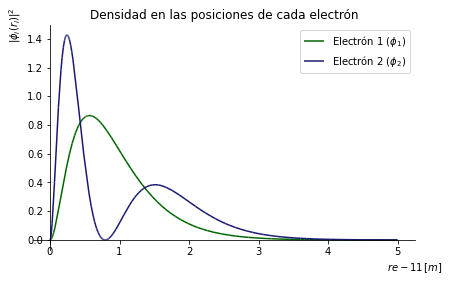

Energías de cada electrón


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Energía total del átomo


<IPython.core.display.Math object>

-------------------------------------------------- Iteración # 4 --------------------------------------------------


<IPython.core.display.Math object>

Función de onda aproximada


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

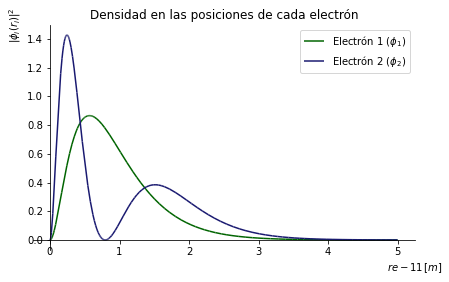

Energías de cada electrón


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Energía total del átomo


<IPython.core.display.Math object>

-------------------------------------------------- Iteración # 5 --------------------------------------------------


<IPython.core.display.Math object>

Función de onda aproximada


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

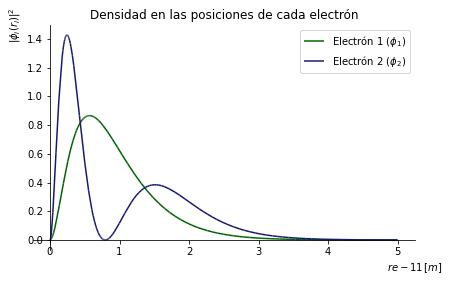

Energías de cada electrón


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Energía total del átomo


<IPython.core.display.Math object>

-------------------------------------------------- Iteración # 6 --------------------------------------------------


<IPython.core.display.Math object>

Función de onda aproximada


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

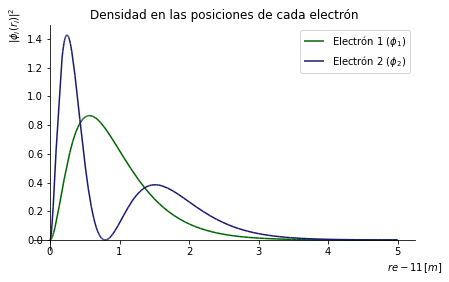

Energías de cada electrón


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Energía total del átomo


<IPython.core.display.Math object>

-------------------------------------------------- Iteración # 7 --------------------------------------------------


<IPython.core.display.Math object>

Función de onda aproximada


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

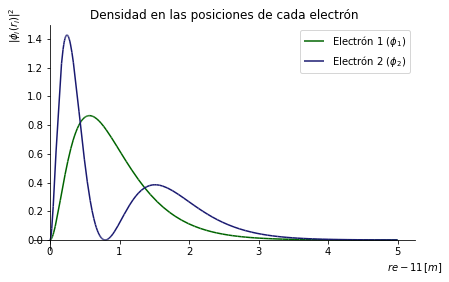

Energías de cada electrón


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Energía total del átomo


<IPython.core.display.Math object>

-------------------------------------------------- Iteración # 8 --------------------------------------------------


<IPython.core.display.Math object>

Función de onda aproximada


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

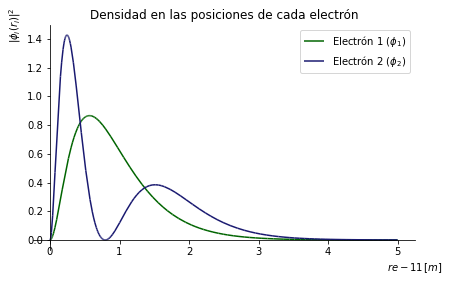

Energías de cada electrón


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Energía total del átomo


<IPython.core.display.Math object>

-------------------------------------------------- Iteración # 9 --------------------------------------------------


<IPython.core.display.Math object>

Función de onda aproximada


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

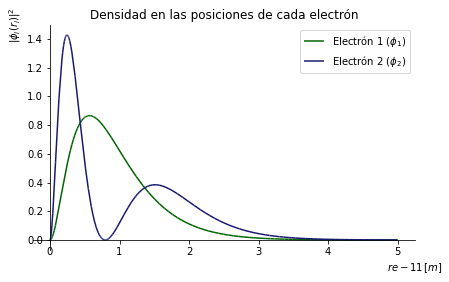

Energías de cada electrón


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Energía total del átomo


<IPython.core.display.Math object>

-------------------------------------------------- Iteración # 10 --------------------------------------------------


<IPython.core.display.Math object>

Función de onda aproximada


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

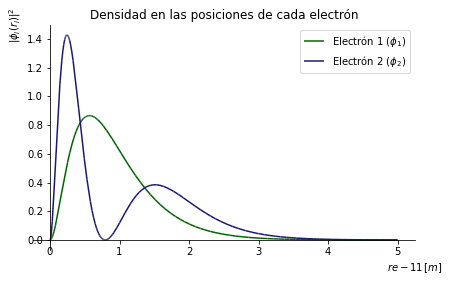

Energías de cada electrón


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Energía total del átomo


<IPython.core.display.Math object>

In [12]:
# Valores iniciales de las zetas y n=1
zetas = [[1.45, 1], [2.91, 1]]
# Número atomico del Helio
Z = 2

# Funciones orbitales
f1=STO(zetas[0][0], zetas[0][1])
f2=STO(zetas[1][0], zetas[1][1])
fs = [f1, f2]

# Caso base (primera aproximación) ##############################################################################
R = np.zeros((len(zetas), len(zetas), len(zetas), len(zetas)))
H = H_mat(fs, Z)
S = S_mat(fs)
e, C = secular(H, S)
P = P_mat(C)
E0 = E_HF(e, P, H)

print('-'*40, "Aproximación inicial", '-'*40)
print('Función Orbital')
display(Math('\chi_i = 2(\zeta_i)^{3/2} e^{-r \zeta_i} ')) 
display(Math('\zeta_1 = {0} \quad \zeta_2 = {1}'.format(format(zetas[0][0], '0.3f'), format(zetas[1][0], '0.3f'), ))) 
print('Función de onda aproximada')
display(Math(' \phi_1 = c_{11} \chi_1 + c_{21} \chi_2 '))
display(Math(' \phi_2 = c_{12} \chi_1 + c_{22} \chi_2 '))    
display(Math('c11 = {0} \quad c21 = {1} '.format(format(C[0][0], '0.10f'), format(C[1][0], '0.10f')))) 
display(Math('c12 = {0} \quad c22 = {1} '.format(format(C[0][1], '0.10f'), format(C[1][1], '0.10f'))))  

# Estimación de la energía
print('Energías de cada electrón')
display(Math(' \epsilon_1 = {0} '.format(format(e[0].real, '0.10f'))))    
display(Math(' \epsilon_2 = {0} '.format(format(e[1].real, '0.10f')))) 
print('Energía total del átomo')
display(Math(' E_0 = {0} \ E_h = {1} \ eV'.format(format(E0, '0.10f'), format(E0*27.211, '0.10f'))))  

# Proceso iterativo ##############################################################################################
M=10 #Numero de iteraciones
for i in range(M):
    print('-'*50, "Iteración #", i + 1, '-'*50)
    if(i==0):
        R = R_mat(zetas)
    else:
        F = F_mat(fs, Z, zetas, C, R)
        S = S_mat(fs)
        e, C = secular(F, S)
        P = P_mat(C)
        E0 = E_HF(e, P, H)

    display(Math('\zeta_1 = {0} \quad \zeta_2 = {1}'.format(format(zetas[0][0], '0.3f'), format(zetas[1][0], '0.3f'), ))) 
    print('Función de onda aproximada') 
    display(Math(' \phi_1 = c_{11} \chi_1 + c_{21} \chi_2 '))
    display(Math(' \phi_2 = c_{12} \chi_1 + c_{22} \chi_2 '))    
    display(Math('c11 = {0} \quad c21 = {1} '.format(format(C[0][0], '0.10f'), format(C[1][0], '0.10f')))) 
    display(Math('c12 = {0} \quad c22 = {1} '.format(format(C[0][1], '0.10f'), format(C[1][1], '0.10f')))) 
    
    #Gráfica de densidad de probabilidad
    phi1 = C[0,0]*f1+C[1,0]*f2
    phi2 = C[0,1]*f1+C[1,1]*f2
    dens1 = phi1*phi1*r*r
    dens2 = phi2*phi2*r*r    
    p1=plot((dens1, (r, 0, 5)), (dens2, (r, 0, 5)), show=False, legend = True, xlabel='$r e-11\, [m]$', ylabel='$|\phi_i(r_i)|^2$', title='Densidad en las posiciones de cada electrón')
    p1[0].label = 'Electrón 1 ($\phi_1$)'
    p1[1].label = 'Electrón 2 ($\phi_2$)'     
    p1[0].line_color = 'darkgreen'
    p1[1].line_color = 'midnightblue'
    p1.show() 
    
    #Energías
    print('Energías de cada electrón')
    display(Math(' \epsilon_1  = {0} '.format(format(e[0].real, '0.10f'))))    
    display(Math(' \epsilon_2  = {0} '.format(format(e[1].real, '0.10f'))))     
    print('Energía total del átomo')
    display(Math('E_0 = {0} \ E_h = {1} \ eV'.format(format(E0, '0.10f'), format(E0*27.211, '0.10f'))))      
    

Los valores experimentales de esta energía rondan los $-2.9\; E_h \sim -79\; eV$, donde
$$E_h=\frac{\hbar c\alpha}{a_0}$$